In [1]:
import itertools as itr
import os
from tqdm import tqdm
from collections import defaultdict

import causaldag as cd
from strategies.simulator import IterationData
from strategies.information_gain import create_info_gain_strategy_dag_collection, create_info_gain_strategy
from strategies.random_nodes import random_strategy

from utils import graph_utils
from analysis.check_gies import get_parent_probs_by_dag, get_l1_score

from config import DATA_FOLDER
samples_folder = os.path.join(DATA_FOLDER, 'check-interventions', 'samples')
os.makedirs(samples_folder, exist_ok=True)

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import xarray as xr
from sklearn import preprocessing

In [3]:
IV_STRENGTH = 5
nnodes = 10
density = .5
target = int(np.ceil(nnodes/2))
nsamples = 2000
N_BOOT = 100
runs = 3
nsamples_obs = 1000
target

5

In [4]:
def tuplify(s):
    a, b = s.split(',')
    return (int(a), int(b))

def detuplify(t):
    a, b = t
    return '%s,%s' % (a, b)

print(tuplify('1,2'))
print(detuplify((1, 2)))

(1, 2)
1,2


In [5]:
np.random.seed(0)
true_dag = cd.rand.directed_erdos(nnodes, density)
true_arcs = {(i+1, i) for i in range(target)} | {(i, i+1) for i in range(target, nnodes-1)}
# true_arcs = {(i+1, i) for i in range(nnodes-1)}
true_dag = cd.DAG(nodes=set(range(nnodes)), arcs=true_arcs)
true_dag.arcs

{(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (5, 6), (6, 7), (7, 8), (8, 9)}

In [6]:
# true_cpdag = true_dag.interventional_cpdag({5}, cpdag=true_dag.cpdag())
true_cpdag = true_dag.cpdag()
true_dag_mec = [cd.DAG(nodes=set(range(nnodes)), arcs=arcs) for arcs in true_cpdag.all_dags()]
intervention_weights = defaultdict(int)
for iv in range(nnodes):
    for poss_dag in true_dag_mec:
        poss_icpdag = poss_dag.interventional_cpdag({iv}, cpdag=true_cpdag)
        intervention_weights[iv] += len(poss_icpdag.arcs) - len(true_cpdag.arcs)
print(intervention_weights)

defaultdict(<class 'int'>, {0: 18, 1: 34, 2: 46, 3: 54, 4: 58, 5: 58, 6: 54, 7: 46, 8: 34, 9: 18})


In [7]:
# arcs = {(i, j): 1 for i, j in true_dag.arcs}
gdag = cd.GaussDAG(nodes=list(range(nnodes)), arcs=true_dag.arcs)
obs_samples_unscaled = gdag.sample(nsamples_obs)
obs_samples = [preprocessing.scale(gdag.sample(nsamples_obs)) for run in range(runs)]
np.diag(np.cov(obs_samples[0], rowvar=False))

array([1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001,
       1.001001, 1.001001, 1.001001, 1.001001])

## Plot the graph

In [8]:
def draw_colored(gdag):
    cmap = plt.get_cmap('seismic')
    
    nw_ax = plt.subplot2grid((10, 10), (0, 0), colspan=9, rowspan=9)
    colorbar_ax = plt.subplot2grid((10, 10), (2, 9), rowspan=6)
    
    plt.gcf().set_size_inches(10, 10)
    d = nx.DiGraph()
    for (i, j), w in gdag.arc_weights.items():
        d.add_edge(i, j, weight=w)
    pos = graphviz_layout(d, 'dot')
    edges = d.edges()
    edge_colors = [(cmap((d[i][j]['weight']+1)/2)) for i, j in edges]
    nx.draw(d, pos=pos, node_color='w', edge_color=edge_colors, ax=nw_ax)
    nx.draw_networkx_labels(d, pos, labels={node: node for node in range(10)}, ax=nw_ax);
    
    cb = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=cmap, orientation='vertical')
    cb.set_ticks([0, .5, 1])
    cb.set_ticklabels([-1, 0, 1])

[5][6|5][7|6][8|7][9|8][4|5][3|4][2|3][1|2][0|1]


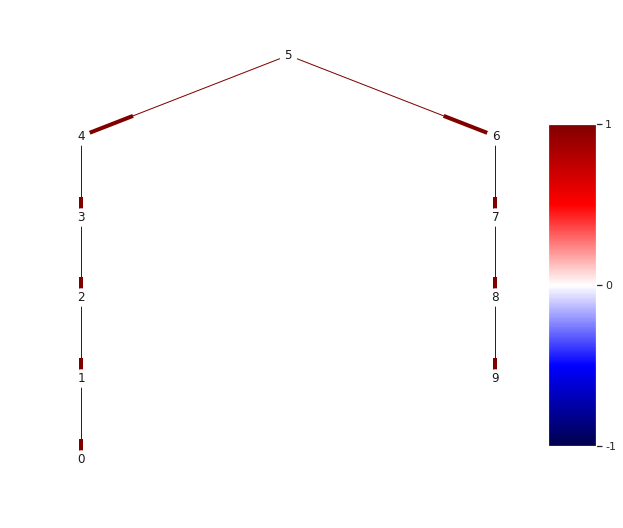

In [9]:
draw_colored(gdag)
print(str(gdag))

In [10]:
g = nx.Graph()
cpdag = true_dag.cpdag()
cpdag.edges

{(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)}

In [11]:
for iv in range(10):
    icpdag = true_dag.interventional_cpdag({iv}, cpdag=cpdag)
    print(iv, ':', icpdag.edges)

0 : {(7, 8), (1, 2), (6, 7), (4, 5), (5, 6), (8, 9), (2, 3), (3, 4)}
1 : {(8, 9), (3, 4), (6, 7), (5, 6), (2, 3), (4, 5), (7, 8)}
2 : {(8, 9), (3, 4), (6, 7), (5, 6), (4, 5), (7, 8)}
3 : {(8, 9), (6, 7), (5, 6), (4, 5), (7, 8)}
4 : {(5, 6), (8, 9), (6, 7), (7, 8)}
5 : set()
6 : {(0, 1), (1, 2), (2, 3), (4, 5), (3, 4)}
7 : {(1, 2), (0, 1), (2, 3), (5, 6), (4, 5), (3, 4)}
8 : {(1, 2), (0, 1), (6, 7), (5, 6), (2, 3), (4, 5), (3, 4)}
9 : {(7, 8), (1, 2), (0, 1), (6, 7), (4, 5), (5, 6), (2, 3), (3, 4)}


In [12]:
intervention_nodes = list(range(nnodes))
interventions = [
    cd.BinaryIntervention(
        intervention1=cd.ConstantIntervention(val=-IV_STRENGTH*std),
        intervention2=cd.ConstantIntervention(val=IV_STRENGTH*std),
    ) for std in np.diag(gdag.covariance)**.5
]

In [ ]:
ivs2dags = defaultdict(list)

# Collect DAGs given just observational data

In [ ]:
for run in tqdm(range(runs)):
    folder = os.path.join(samples_folder, 'observational,run%d' % run)
    os.makedirs(folder)
    samples_file = os.path.join(folder, 'samples.csv')
    interventions_folder = os.path.join(folder, 'interventions')
    gies_dags_folder = os.path.join(folder, 'gies_dags/')

    graph_utils._write_data({-1: obs_samples[run]}, samples_file, interventions_folder)
    graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)
    amats, dags = graph_utils._load_dags(gies_dags_folder)

    ivs2dags[-1].append(dags)

# Collect DAGs given interventional data

In [ ]:
for iv_node, intervention in tqdm(zip(intervention_nodes, interventions), total=len(interventions)):
    for run in range(runs):
        samples = gdag.sample_interventional({iv_node: intervention}, nsamples)
        samples = preprocessing.scale(samples)
        all_samples = {-1: obs_samples[run], iv_node: samples}
        folder = os.path.join(samples_folder, 'iv=%d,run%d' % (iv_node, run))
        os.makedirs(folder)

        samples_file = os.path.join(folder, 'samples.csv')
        interventions_folder = os.path.join(folder, 'interventions')
        gies_dags_folder = os.path.join(folder, 'gies_dags/')
        graph_utils._write_data(all_samples, samples_file, interventions_folder)
        graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)

        amats, dags = graph_utils._load_dags(gies_dags_folder)
        ivs2dags[iv_node].append(dags)

# Count the occurrences of each arc in the sampled DAGs

In [ ]:
ivs2parent_probs = xr.DataArray(
    np.zeros([len(interventions) + 1, len(gdag.nodes), runs]),
    dims=['iv_node', 'parent', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'parent': gdag.nodes,
        'run': list(range(runs))
    }
)
possible_arcs = list(itr.permutations(gdag.nodes, 2))
ivs2arc_probs = xr.DataArray(
    np.zeros([len(interventions) + 1, len(possible_arcs), runs]),
    dims=['iv_node', 'arc', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'arc': list(map(detuplify, possible_arcs)),
        'run': list(range(runs))
    }
)
for iv_node, dags_by_run in ivs2dags.items():
    for run, dags in enumerate(dags_by_run):
        parent_counts = {node: 0 for node in gdag.nodes}
        arc_counts = defaultdict(int)
        for dag in dags:
            for p in dag.parents[target]:
                parent_counts[p] += 1
            for arc in dag.arcs:
                arc_counts[arc] += 1
        for parent, count in parent_counts.items():
            ivs2parent_probs.loc[dict(run=run, iv_node=iv_node, parent=p)] = count/len(dags)
        for arc, count in arc_counts.items():
            ivs2arc_probs.loc[dict(run=run, iv_node=iv_node, arc=detuplify(arc))] = count/len(dags)

# From the arc occurrences, compute l1 scores

#### functions

In [ ]:
def l1_score_full(arc_probs, gdag):
    possible_arcs = set(itr.permutations(gdag.nodes, 2))
    nonarcs = possible_arcs - gdag.arcs
    return sum(1-arc_probs[arc] for arc in gdag.arcs) + sum(arc_probs[nonarc] for nonarc in nonarcs)


def l1_score_fp_full(arc_probs, gdag):
    possible_arcs = set(itr.permutations(gdag.nodes, 2))
    nonarcs = possible_arcs - gdag.arcs
    return sum(arc_probs[nonarc] for nonarc in nonarcs)


def l1_score_fn_full(arc_probs, gdag):
    return sum(1-arc_probs[arc] for arc in gdag.arcs)

#### actual computation

In [ ]:
ivs2scores = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
for iv_node in intervention_nodes + [-1]:
    for run in range(runs):
        parent_probs = {node: ivs2parent_probs.sel(iv_node=iv_node, parent=node, run=run) for node in gdag.nodes}
        ivs2scores.loc[dict(iv_node=iv_node, run=run)] = get_l1_score(parent_probs, gdag, target)

max_l1_loss_full = nnodes*(nnodes-1)
max_l1_loss_fn = len(gdag.arcs)
max_l1_loss_fp = max_l1_loss_full - max_l1_loss_fn
ivs2full_scores = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
ivs2full_scores_fp = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
ivs2full_scores_fn = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
for iv_node in intervention_nodes + [-1]:
    for run in range(runs):
        arc_probs = {arc: ivs2arc_probs.sel(iv_node=iv_node, arc=detuplify(arc), run=run).values.item() for arc in possible_arcs}
        ivs2full_scores.loc[dict(iv_node=iv_node, run=run)] = l1_score_full(arc_probs, gdag)
        ivs2full_scores_fp.loc[dict(iv_node=iv_node, run=run)] = l1_score_fp_full(arc_probs, gdag)
        ivs2full_scores_fn.loc[dict(iv_node=iv_node, run=run)] = l1_score_fn_full(arc_probs, gdag)

        

# Plot effectiveness of each intervention

#### L1-score targeting just learning parents

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2scores.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2scores.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2scores.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2scores.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss on edges coming into node 5')
plt.legend();

#### L1-score on full graph

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss on all edges')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_full), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

#### L1-score on false negatives

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores_fn.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss with only false negatives')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_fn), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

#### L1-score on false positives

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores_fp.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss with only false positives')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_fp), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

In [ ]:
# def get_parent_functional(parent):
#     def parent_functional(dag):
#         return parent in dag.parents[target]
#     return parent_functional

# parent_functionals = [get_parent_functional(node) for node in gdag.nodes if node != target]

In [ ]:
# info_strat = create_info_gain_strategy(50, parent_functionals)

# info_strat(iteration_data)

In [ ]:
ivs2parent_probs.sel(iv_node=0, run=1)

In [ ]:
ivs2parent_probs.sel(iv_node=0, run=2)

In [ ]:
ivs2scores.sel(iv_node=0, run=1)

In [ ]:
ivs2scores.sel(iv_node=0, run=2)

In [ ]:
ivs2scores.sel(iv_node=0, run=0)

In [ ]:
def marginal_network(ivs2arc_probs, iv, run, mode='both'):
    arc_probs = ivs2arc_probs.sel(iv_node=iv, run=run)
    d = nx.DiGraph()
    d.add_nodes_from(gdag.nodes)
    for arc, prob in zip(possible_arcs, arc_probs.data):
        i, j = arc
        if prob != 0:
            if mode == 'both' or (mode == 'forward' and i<j) or (mode == 'backward' and i > j):
                d.add_edge(*arc, weight=prob)
    return d

In [ ]:
draw_colored(gdag)

In [ ]:
cmap = plt.get_cmap('Greys')
fig, axes = plt.subplots(len(interventions)+1, runs*2)
unit = 6
width = unit*runs*2
height = unit*(len(interventions) + 1)
fig.set_size_inches(width, height)

pos = nx.circular_layout(gdag.nodes)

for run in range(runs):
    for iv_ix, iv_node in enumerate([-1] + intervention_nodes):
        forward_ax = axes[iv_ix, run*2]
        backward_ax = axes[iv_ix, run*2+1]
        
        m = marginal_network(ivs2arc_probs, iv_node, run, mode='forward')
        edges = m.edges()
        edge_colors = [cmap(m[i][j]['weight']) for i, j in edges]
        nx.draw(m, pos=pos, node_color='w', edge_color=edge_colors, ax=forward_ax)
        nx.draw_networkx_edges(m, pos, edge_color=edge_colors, ax=forward_ax, arrowstyle='fancy')
        nx.draw_networkx_labels(m, pos, labels={node: node for node in range(10)}, ax=forward_ax)
        
        m = marginal_network(ivs2arc_probs, iv_node, run, mode='backward')
        edges = m.edges()
        edge_colors = [cmap(m[i][j]['weight']) for i, j in edges]
        nx.draw(m, pos=pos, node_color='w', edge_color=edge_colors, ax=backward_ax)
        nx.draw_networkx_edges(m, pos, edge_color=edge_colors, ax=backward_ax, arrowstyle='fancy')
        nx.draw_networkx_labels(m, pos, labels={node: node for node in range(10)}, ax=backward_ax);
        
        if iv_ix == 0:
            forward_ax.set_title('Run %d' % run)
            backward_ax.set_title('Run %d' % run)
        if run == 0:
            forward_ax.text(-1, -1, 'I=%s' % iv_node if iv_node != -1 else 'Obs')

In [ ]:
gdag.arcs

In [ ]:
ivs2full_scores_fp

In [ ]:
ivs2full_scores_fn

In [ ]:
ivs2full_scores

In [ ]:
len(true_dag_mec)

In [13]:
def get_isdag_functional(dag):
    def isdag(test_dag):
        return dag.arcs == test_dag.arcs
    return isdag

mec_functionals = [get_isdag_functional(dag) for dag in true_dag_mec]
list(map(lambda m: m(true_dag), mec_functionals))

[True, False, False, False, False, False, False, False, False, False]

In [14]:
iv_samples = gdag.sample_interventional({0: interventions[0]}, 10)
print(iv_samples)

[[ 12.24744871   2.45548054   3.08191332   1.41840763   1.71582005
    0.59840522   1.84693602   3.44008357   3.18584206   3.93476245]
 [ 12.24744871   1.00991775   0.75992979   2.49868946   1.44148643
    2.23202622   1.73637655   2.67502664   2.06251858   1.66763611]
 [ 12.24744871  -0.89697428  -2.24676246  -2.66052444  -1.21897428
   -0.08981204  -0.15083976  -0.61157742  -0.15187012   0.84958046]
 [-12.24744871  -0.6774503   -0.94911896  -0.72322068  -2.29934733
   -1.14901352   1.29571408   0.89544207  -0.21323447  -0.19815427]
 [-12.24744871   1.84813083   0.82071102   0.59392837   0.22065033
    0.29738849   0.01800641  -1.16361363  -1.29860286  -0.94370453]
 [ 12.24744871  -5.22328624  -3.03776096  -3.36093664  -1.35461309
   -0.85927526  -2.732114    -1.72299765  -2.20590778  -2.17110533]
 [ 12.24744871   1.0482167    0.34686523   0.8401495    0.07554267
   -0.84000466  -0.86209449   0.99608369   2.37878542   2.42242873]
 [-12.24744871  -1.40507982  -0.03885464  -0.6886185   

In [15]:
dag_collection_info_strat = create_info_gain_strategy_dag_collection(true_dag_mec, mec_functionals)
bootstrap_info_strat = create_info_gain_strategy(100, mec_functionals)

dag_collection_info_strat_folder = os.path.join(DATA_FOLDER, 'dag-collection-info-test-line/')
bootstrap_info_strat_folder = os.path.join(DATA_FOLDER, 'bootstrap-info-test-line/')
os.makedirs(dag_collection_info_strat_folder, exist_ok=True)
os.makedirs(bootstrap_info_strat_folder, exist_ok=True)


iteration_data_dag_collection_info_strat = IterationData(
    current_data={-1: obs_samples_unscaled, 0: iv_samples},
    max_interventions=2,
    n_samples=200,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=dag_collection_info_strat_folder,
    precision_matrix=gdag.precision
)
iteration_data_bootstrap_info_strat = IterationData(
    current_data={-1: obs_samples_unscaled},
    max_interventions=4,
    n_samples=1000,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=bootstrap_info_strat_folder,
    precision_matrix=gdag.precision
)

In [16]:
dag_collection_interventions = dag_collection_info_strat(iteration_data_dag_collection_info_strat)

 50%|█████     | 5/10 [00:00<00:00, 44.74it/s]

{0: BinaryIntervention(intervention1=ConstantIntervention(val=-12.24744871391589), intervention2=ConstantIntervention(val=12.24744871391589), p=0.5)}
[1.11111111e-001 1.11111111e-001 1.11111111e-001 1.11111111e-001
 1.11111111e-001 6.87970021e-259 1.11111111e-001 1.11111111e-001
 1.11111111e-001 1.11111111e-001]
COLLECTING DATA POINTS
CALCULATING LOG PDFS



100%|██████████| 200/200 [00:21<00:00,  8.77it/s]


In [17]:
iteration_data_random = IterationData(
    current_data={-1: obs_samples_unscaled},
    max_interventions=2,
    n_samples=200,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=os.path.join(DATA_FOLDER, 'test-random'),
    precision_matrix=gdag.precision
)
random_datas = []
for i in range(10):
    random_interventions = random_strategy(iteration_data_random)
    print(random_interventions)
    random_data = {iv: gdag.sample_interventional({iv: interventions[iv]}, samples) for iv, samples in random_interventions.items()}
    random_data[-1] = obs_samples_unscaled
    random_datas.append(random_data)
    

{2: 100, 8: 100}
{3: 100, 7: 100}
{4: 100, 0: 100}
{5: 100, 2: 100}
{5: 100, 2: 100}
{0: 100, 5: 100}
{3: 100, 5: 100}
{7: 100, 5: 100}
{8: 100, 3: 100}
{9: 100, 6: 100}


In [18]:
dag_collection_data = {iv: gdag.sample_interventional({iv: interventions[iv]}, samples) for iv, samples in dag_collection_interventions.items()}
dag_collection_data[-1] = obs_samples_unscaled

In [ ]:
def get_gies_dags(samples_dict, foldername):
    folder = os.path.join(DATA_FOLDER, foldername)
    os.makedirs(folder, exist_ok=True)

    samples_file = os.path.join(folder, 'samples.csv')
    interventions_folder = os.path.join(folder, 'interventions')
    gies_dags_folder = os.path.join(folder, 'gies_dags/')
    graph_utils._write_data(samples_dict, samples_file, interventions_folder)
    graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)

    amats, dags = graph_utils._load_dags(gies_dags_folder)
    return dags

In [ ]:
def get_arc_probs(dags):
    arc_counts = defaultdict(int)
    for dag in dags:
        for arc in dag.arcs:
            arc_counts[arc] += 1
    return defaultdict(float, {arc: count/len(dags) for arc, count in arc_counts.items()})

In [ ]:
dag_collection_info_dags = get_gies_dags(dag_collection_data, 'dag-collection')
dag_collection_arc_probs = get_arc_probs(dag_collection_info_dags)

In [ ]:
random_dags_list = [get_gies_dags(random_data, 'random%d' % i) for i, random_data in enumerate(random_datas)]

In [ ]:
random_dags_arc_probs_list = [get_arc_probs(random_dags) for random_dags in random_dags_list]

In [ ]:
dag_collection_l1_score = l1_score_full(dag_collection_arc_probs, gdag)
dag_collection_l1_score_fn = l1_score_fn_full(dag_collection_arc_probs, gdag)
dag_collection_l1_score_fp = l1_score_fp_full(dag_collection_arc_probs, gdag)

print('DAG COLLECTION L1 SCORE:', dag_collection_l1_score)
print('DAG COLLECTION L1 SCORE FN:', dag_collection_l1_score_fn)
print('DAG COLLECTION L1 SCORE FP:', dag_collection_l1_score_fp)

In [ ]:
random_dag_l1_scores = [l1_score_full(random_dags_arc_probs, gdag) for random_dags_arc_probs in random_dags_arc_probs_list]
random_dag_l1_scores_fp = [l1_score_fp_full(random_dags_arc_probs, gdag) for random_dags_arc_probs in random_dags_arc_probs_list]
random_dag_l1_scores_fn = [l1_score_fn_full(random_dags_arc_probs, gdag) for random_dags_arc_probs in random_dags_arc_probs_list]

In [ ]:
print(np.mean(random_dag_l1_scores))
print(np.mean(random_dag_l1_scores_fn))
print(np.mean(random_dag_l1_scores_fp))


In [ ]:
get_gies_dags(random_datas[0], 'random0')